In [20]:
import os
import matplotlib.pyplot as plt
import CGRtools
import multiprocessing

from tqdm import tqdm
from rdkit import Chem

def cgr_representation(rxn_smiles):
    r = CGRtools.smiles(rxn_smiles)
    r.clean2d()
    cgr = ~r
    return cgr.__str__()

def mp_wrapper_cgr(lines, ncpus=32):
    rxn_smiles_list, reaction_id_list = list(zip(*[line.split("\t") for line in lines]))
    with multiprocessing.Pool(processes=ncpus) as pool:
        cgr_list = pool.map(cgr_representation, rxn_smiles_list)
    return {reaction_id: cgr for reaction_id, cgr in zip(reaction_id_list, cgr_list)}

fractions = [3, 5, 10, 15, 20]
thresholds = [1, 3, 5]

In [3]:
golden_data_path = "../data_USPTO_50k_coley/USPTO_50k_coley.txt"
with open(golden_data_path, "r") as f:
    golden_lines = f.readlines()
golden_id2cgr_dict = mp_wrapper_cgr(golden_lines)
num_total_data = len(golden_id2cgr_dict)

In [5]:
threshold_performance = {1:[], 3:[], 5:[]}
for threshold in thresholds:
    for fraction in tqdm(fractions):
        data_path = f"../data_USPTO_50k_noise/USPTO_50k_{fraction}perc_noise/threshold_{threshold}/USPTO_50k_{fraction}perc_noise.txt.processed"
        with open(data_path, "r") as f:
            prcessed_lines = f.readlines()
        prcessed_id2cgr_dict = mp_wrapper_cgr(prcessed_lines)
    
        num_cgr_false = 0
        for reaction_id in prcessed_id2cgr_dict.keys():
            if prcessed_id2cgr_dict[reaction_id] != golden_id2cgr_dict[reaction_id]:
                # print(reaction_id, prcessed_id2cgr_dict[reaction_id], golden_id2cgr_dict[reaction_id])
                num_cgr_false += 1
        num_correct = len(prcessed_id2cgr_dict) - num_cgr_false
        residual_proportion = num_correct / num_total_data
        threshold_performance[threshold].append(residual_proportion)

100%|██████████| 6/6 [01:41<00:00, 16.89s/it]


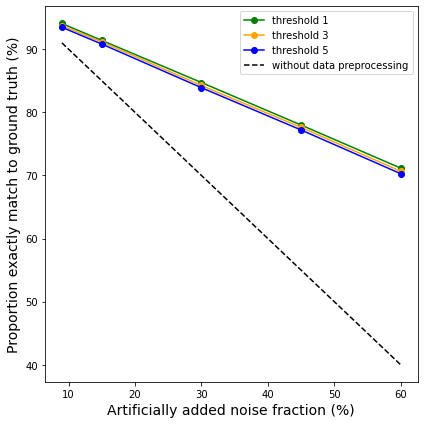

In [28]:
fractions = [3, 5, 10, 15, 20]

fig, ax = plt.subplots(figsize=(6,6))
noise_fractions = [x*3 for x in fractions]
noise_resiudal = [100 - x for x in noise_fractions]
color_dict = {1: "green", 3: "orange", 5: "blue"}

for threshold in thresholds:
    performance = threshold_performance[threshold]
    performance = [100*x for x in performance]
    ax.plot(noise_fractions, performance, color=color_dict[threshold], marker="o", label="threshold "+str(threshold))

ax.plot(noise_fractions, noise_resiudal, color="black", linestyle='dashed', label="without data preprocessing")
ax.set_xlabel("Artificially added noise fraction (%)", fontsize=14)
ax.set_ylabel('Proportion exactly match to ground truth (%)', fontsize=14)

ax.legend()
plt.tight_layout()
plt.savefig("../docs/noise_experiments.svg", format="svg")
plt.show()


In [11]:
noise_resiudal

[97, 91, 85, 70, 55, 40]